# Introduction

This report presents the use of decision trees and random forest models to predict the metallic glass forming ability of the Co-Zr-Cr-Ti quaternary system. Alloys of differing compositions are labelled as either AM (amorphorous, or, 0) or CR (crystalline, or, 1). The predictions produced from the decision tree and random forest models will then be compared to determine the feasibility of using such models to predict material properties. 

# 0.0 Auxiliary Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker
import matplotlib.patches as patches

# from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, LeaveOneGroupOut, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import Miedema, YangSolidSolution, Meredig, AtomicPackingEfficiency, BandCenter, WenAlloys

In [2]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

In [3]:
# Using ChatGPT
def drop_high_correlation_columns(df, threshold=0.8):
    # Calculate the correlation matrix for the dataframe
    corr_matrix = df.corr().abs()
    # Get the upper triangle of the correlation matrix (excluding the diagonal)
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    # Find the columns that have a correlation greater than or equal to the threshold
    high_corr_cols = [col for col in upper_triangle.columns if any(upper_triangle[col] >= threshold)]
    # Drop the high correlation columns from the dataframe
    df = df.drop(columns=high_corr_cols)
    return df

In [4]:
def drop_constant_columns(df):
    columns = df.columns
    drop_cols = []
    # Iterate over the columns and check if they have constant values
    for col in columns:
        if df[col].nunique() == 1:
            drop_cols.append(col)
    #Drop the constant columns
    result_df = df.drop(drop_cols, axis=1)
    return result_df

In [5]:
def drop_nonnumeric_columns(df, exclude_cols=None):
    # get the column names
    columns = df.columns
    # create a list to store the non-numeric columns to drop
    drop_cols = []
    # iterate over the columns and check if they are non-numeric
    for col in columns:
        if not np.issubdtype(df[col].dtype, np.number):
            # check if the column is in the exclude list
            if exclude_cols is None or col not in exclude_cols:
                drop_cols.append(col)
    # drop the non-numeric columns
    result_df = df.drop(drop_cols, axis=1)
    return result_df

In [6]:
# # Using ChatGPT
# def multiply_columns(df, exclude_cols=None, column_name_template="{col1}_{col2}"):
#     # Set default value of exclude_cols to an empty list
#     if exclude_cols is None:
#         exclude_cols = []
#     # Keep adding new columns until there are 100 columns in total
#     while len(df.columns) < 100:
#         # Get the names of the columns that have not been excluded
#         available_cols = [col for col in df.columns if col not in exclude_cols]
        
#         # Randomly choose two columns to multiply
#         col1, col2 = np.random.choice(available_cols, size=2, replace=False)
        
#         # Generate the name of the new column
#         new_col_name = column_name_template.format(col1=col1, col2=col2)
        
#         # Multiply the two columns and add the result as a new column to the dataframe
#         df[new_col_name] = df[col1] * df[col2]
    
#     return df


In [7]:
def tree_cv(df, cv_type='random', n_splits=5, model_type=None, print_class_distribution=False):
    X = df.iloc[:, 1:-1]
    y = df.iloc[:, 0]
    groups = df["Cluster"]
    
    if cv_type == 'loco':
        cv = LeaveOneGroupOut()
        cv = cv.split(X, groups = groups)
    elif cv_type == 'random':
        cv = StratifiedShuffleSplit(n_splits=n_splits, test_size = 0.2)
        cv = cv.split(X, y)
    else:
        raise ValueError('Invalid cross-validation type. Choose "loco" or "random".')
        
    cv_scores = [] # Contains accuracy scores on test set of each fold
    test_errors = [] # Contains test set error of each fold
    train_errors = [] # Contains training set error of each fold
    
    for train_index, test_index in cv:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if model_type == "decisiontree":
            # Define model
            model = tree.DecisionTreeClassifier(random_state=0)
        
        elif model_type == "randomforest":
            model = RandomForestClassifier(random_state=0)
            
        else:
            raise ValueError('Invalid model type. Choose "decisiontree" or "randomforest".')
        # Standardize features
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Get model predictions on testing data in fold
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Append accuracy score 
        accuracy = accuracy_score(y_test, y_pred)
        cv_scores.append(accuracy)
        
        # Calculate training and testing set errors
        test_error = 1 - model.score(X_test, y_test)
        train_error = 1 - model.score(X_train, y_train)
        test_errors.append(test_error)
        train_errors.append(train_error)
        
        # plot confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4, 4))
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.xticks([0, 1])
        plt.yticks([0, 1])
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.grid(False)
        for i in range(2):
            for j in range(2):
                plt.text(j, i, format(conf_matrix[i, j], '.2f'),
                         horizontalalignment="center",
                         color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")        
        plt.show()
        
        # plot AUC-ROC curve
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = roc_auc_score(y_test, y_score)
        plt.figure(figsize=(4, 4))
        plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()

        # Print test/train errors
        print(f'The training error is {round(train_error * 100, 4)} %')
        print(f'The test error is {round(test_error * 100, 4)} % ')
        

    return cv_scores, test_errors, train_errors

In [8]:
def percent_fmt(x, pos):
    return f"{x*100:.0f}%"

# Used ChatGPT and modified code
def plot_dataframe(df, color_col, overlay_rect=False, title=None):
    # Extract the x, y, and color values from the DataFrame
    x = df.loc[:, 'Yang delta']
    y = df.loc[:, 'Yang omega']
    c = df[color_col]
    
    # Create a scatter plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=c)
    
    # Add labels and a color bar
    ax.set_xlabel(df.columns[0])
    ax.set_ylabel(df.columns[1])
    cbar = fig.colorbar(ax.collections[0])
    cbar.set_label(color_col)  # Add label to the color bar
    
    # Format the x-axis as percentages
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(percent_fmt))
    ax.set_ylim(bottom=0, top= 5)
    
    if overlay_rect:
        rect = patches.Rectangle((0.05, 0.3), 0.13, 1.2, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the plot
    plt.title(f"Yang Plot of Glass Formation Predictions")
    caption = f"0 indicates glass-forming (AM), 1 indicates not glass-forming (CR)"
    ax.text(0.5, -0.2, caption, transform=ax.transAxes, ha='center')
    
    if title:
        plt.title(title)
    plt.show()

# 1.0 Data pre-processing

I used Excel to convert the glass.data file to a .csv. I import this .csv below as the raw data

In [9]:
raw_data = pd.read_csv("glassdataexcel.csv")
raw_data.columns = ["Formula", "gfa"]
# Replace all AC with CR for simplicity
raw_data[raw_data["gfa"] == "AC"] = "CR"
raw_data.shape

(6836, 2)

In [10]:
# Drop rows containing NaN values
clean_data = raw_data
clean_data = clean_data.dropna()
# Drop duplicated compositions
clean_data = clean_data.drop_duplicates(subset="Formula")
# Replace AM with 0 and CR with 1
clean_data['gfa'] = clean_data['gfa'].replace({'AM': 0, 'CR': 1})
clean_data.shape

(5224, 2)

In [11]:
# Drop rows with CR or "AW" in the "Formula" column
mask = (clean_data["Formula"] != "CR") & (clean_data["Formula"] != "AM")
clean_data = clean_data.loc[mask]
print(clean_data.shape)
clean_data["gfa"].value_counts()

(5223, 2)


0    4070
1    1153
Name: gfa, dtype: int64

## 1.1 Featurization

In [12]:
# str_comp = StrToComposition(target_col_id='composition')
# featurized_data = str_comp.featurize_dataframe(clean_data, col_id='Formula')
# featurized_data.to_csv("datawithcomposition.csv")

In [13]:
# featurized_data = WenAlloys().featurize_dataframe(featurized_data, "composition")

In [14]:
# featurized_data.to_csv("featurized_data_wenalloys.csv")

In [15]:
# featurized_data = WenAlloys().featurize_dataframe(featurized_data, col_id="composition")

In [16]:
# featurized_data = Meredig().featurize_dataframe(featurized_data, col_id="composition")

In [17]:
# featurized_data.to_csv("featurized_data_meredig.csv")

In [18]:
# featurized_data = AtomicPackingEfficiency().featurize_dataframe(featurized_data, col_id="composition")

In [19]:
# featurized_data.to_csv("raw_featurized_data_nonedropped.csv")

Featurizing takes ~ 50 minutes. Please load the following **raw_featurized_data_nonedropped.csv** to get the raw featurized data

In [20]:
raw_featurized_data = pd.read_csv("raw_featurized_data_nonedropped.csv")

In [21]:
# drop columns with constant values
raw_featurized_data_only_numeric = drop_constant_columns(raw_featurized_data)
# drop non-numeric columns
raw_featurized_data_only_numeric = drop_nonnumeric_columns(raw_featurized_data_only_numeric, exclude_cols="gfa")

In [22]:
# Add three  polynomial combinations of two features
polynomial_featurized_data = raw_featurized_data_only_numeric
polynomial_featurized_data["APE mean_Radii gamma Product"] = polynomial_featurized_data["APE mean"] * polynomial_featurized_data["Radii gamma"]
polynomial_featurized_data["APE mean_squared"] = polynomial_featurized_data["APE mean"] ** 2
polynomial_featurized_data["APE mean_Total weight Product"] = polynomial_featurized_data["APE mean"] * polynomial_featurized_data["Total weight"]
polynomial_featurized_data = polynomial_featurized_data.dropna()

## 1.2 Drop highly correlated features

Features with a correlation coefficient greater than abs(0.7) were dropped. This stricter criterion was used to drop more features than using a threshold of abs(0.8) to make random forest training faster (less features to train on).

In [23]:
# Drop highly correlated features with correlation > abs(0.7)
reduced_featurized_data = drop_high_correlation_columns(polynomial_featurized_data, threshold=0.7)

# 2.0 Training a decision tree

## 2.1 Perform LOCO-CV by splitting the dataset using your choice of clustering tool

### 2.1.1 K-means clustering

In [24]:
reduced_featurized_data_std = reduced_featurized_data
reduced_featurized_data_std = reduced_featurized_data_std.to_numpy()
reduced_featurized_data_scaler = StandardScaler()
reduced_featurized_data_scaler.fit(reduced_featurized_data_std)
reduced_featurized_data_std = reduced_featurized_data_scaler.transform(reduced_featurized_data_std)

n_components = min(len(reduced_featurized_data_std[:,0]), len(reduced_featurized_data_std[0,:]))

pca = PCA(n_components)
pca.fit(reduced_featurized_data_std)
pos = pca.transform(reduced_featurized_data_std)

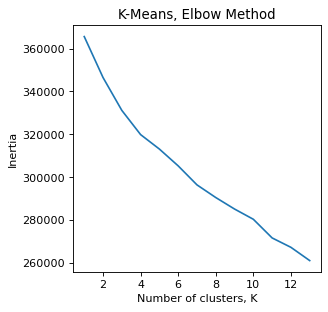

In [25]:
inertias = {}

for k in range(1, 14):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pos)
    inertias[k] = kmeans.inertia_ 

figure(figsize=(4,4), dpi=80)
plt.plot(list(inertias.keys()), list(inertias.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Inertia");

From inertia analysis, it appears that there is an elbow at K = 4. As a result, all data points will be assigned to four clusters

In [26]:
# Conduct clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state = 0).fit(pos)
L = list(kmeans.labels_)
# assign colours to the labels
clist = ['r','g','b','k','c','m','y'] # for up to 7 colors
for cl in range(k):
    L = [clist[cl] if i==cl else i for i in L]

In [27]:
# Add cluster label to all data points
clustered_reduced_featurized_data = reduced_featurized_data
clustered_reduced_featurized_data["Cluster"] = pd.DataFrame(L)

### 2.1.2 Performing LOCO CV using KNN clusters

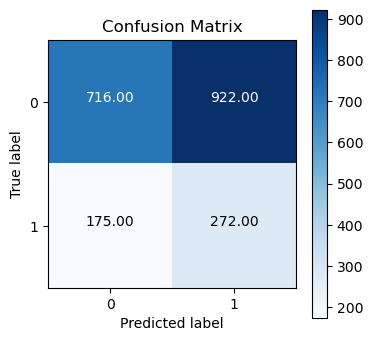

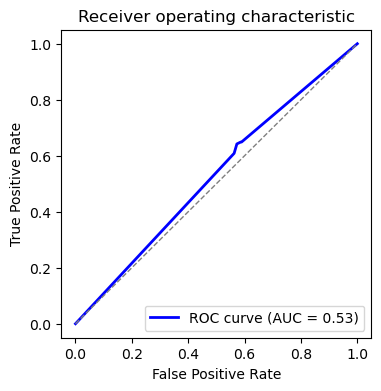

The training error is 0.2868 %
The test error is 52.6139 % 


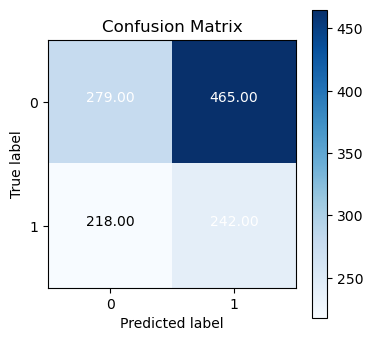

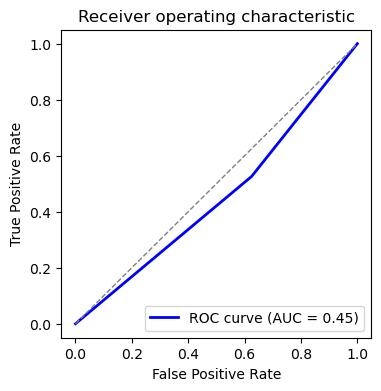

The training error is 0.3483 %
The test error is 56.7276 % 


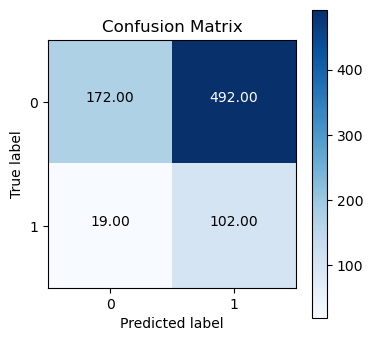

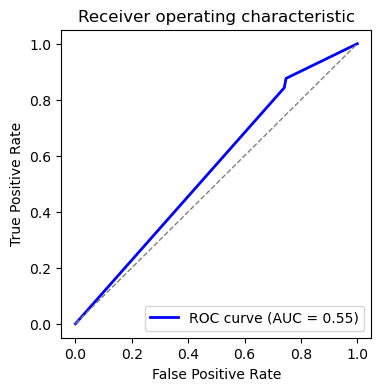

The training error is 0.3605 %
The test error is 65.0955 % 


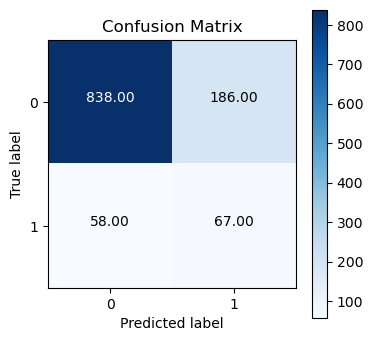

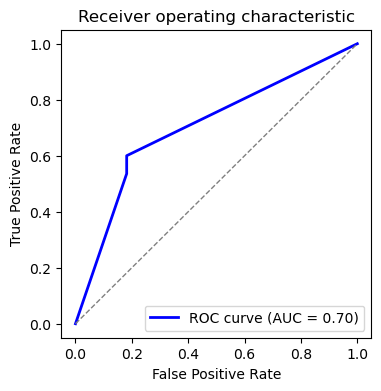

The training error is 0.2209 %
The test error is 21.2359 % 


In [28]:
loco_scores, loco_test_errors, loco_trainerrors = tree_cv(clustered_reduced_featurized_data, cv_type='loco', model_type="decisiontree")

## 2.2 Perform random CV in conjunction with hyperparameter tuning

Performing grid search to tune max_depth and min_samples_split hyperparameters:

In [29]:
# Split reduced, clustered, featurized data into X and Y values
randomcv_X = clustered_reduced_featurized_data.iloc[:, 1:-1]
randomcv_y = clustered_reduced_featurized_data.iloc[:, 0]

From varying the max_depth, it appears that the optimal max_depth occurs between the range of 5-15. From varying the max_samples_split, it appears that the optimal min_samples_split occurs withing 2-10. 

As a result, both of these hyperparameters were further tuned within a sub-interval of these two ranges, as shown below:

Training and test set errors from grid search:

Test error: 0.127 (+/-0.014), Training error: 0.095 (+/-0.008) for {'max_depth': 8, 'min_samples_split': 2}
Test error: 0.126 (+/-0.014), Training error: 0.095 (+/-0.007) for {'max_depth': 8, 'min_samples_split': 3}
Test error: 0.127 (+/-0.014), Training error: 0.096 (+/-0.008) for {'max_depth': 8, 'min_samples_split': 4}
Test error: 0.127 (+/-0.015), Training error: 0.096 (+/-0.007) for {'max_depth': 8, 'min_samples_split': 5}
Test error: 0.127 (+/-0.015), Training error: 0.096 (+/-0.007) for {'max_depth': 8, 'min_samples_split': 6}
Test error: 0.120 (+/-0.012), Training error: 0.085 (+/-0.010) for {'max_depth': 9, 'min_samples_split': 2}
Test error: 0.120 (+/-0.011), Training error: 0.085 (+/-0.010) for {'max_depth': 9, 'min_samples_split': 3}
Test error: 0.119 (+/-0.013), Training error: 0.086 (+/-0.010) for {'max_depth': 9, 'min_samples_split': 4}
Test error: 0.120 (+/-0.014), Training error: 0.087 (+/-0.010) for {'max_depth': 9, 'min

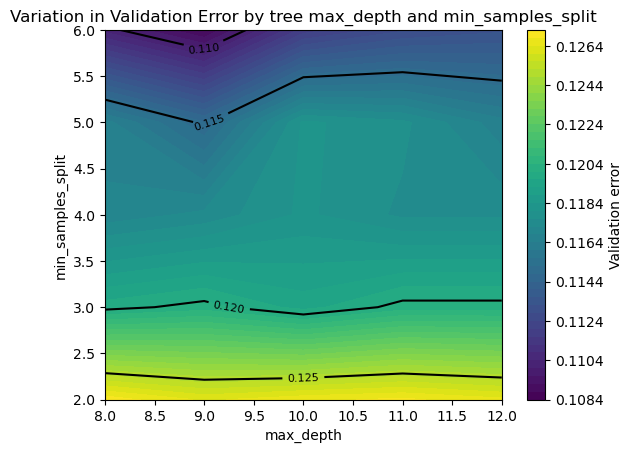

In [30]:
tuned_parameters = {'max_depth': [8,9,10,11,12], 
                     'min_samples_split': [2,3,4,5,6]}
# Compute accuracy from lab 9
# Error is 1 - accuracy
scores = ['accuracy'] 
for score in scores:
   
    splitting_type = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    clf = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tuned_parameters,
                       scoring = f'{score}', return_train_score=True, cv=splitting_type)
    clf.fit(randomcv_X, randomcv_y)
    print("Training and test set errors from grid search:")
    print()
    # Get mean validation accuracy over folds for each pair of hyperparameters
    means = clf.cv_results_["mean_test_score"]
    # Get mean training accuracy over folds for each pair of hyperparameters
    train_means = clf.cv_results_["mean_train_score"]
    # Get standard deviation of validation accuracy scores 
    stds = clf.cv_results_["std_test_score"]
    # Get standard deviation of training accuracy scores 
    train_stds = clf.cv_results_["std_train_score"]
    # Report your training and validation errors
    for mean, std, train_means, train_stds, params in zip(means, stds, train_means, train_stds, clf.cv_results_['params']):
        print(f"Test error: {1 - mean:0.3f} (+/-{std*2:0.03f}), Training error: {1 - train_means:0.3f} (+/-{train_stds*2:0.03f}) for {params}")

# Plot contour plot
X, Y = np.meshgrid(tuned_parameters['max_depth'], tuned_parameters['min_samples_split'])
# Color is validation error = 1 - mean validation accuracy
Z = np.array(1 - means).reshape(5,5)
plt.figure()
plt.contourf(X, Y, Z, 50)
plt.colorbar(label='Validation error');
contours = plt.contour(X, Y, Z, 3, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel('max_depth')
plt.ylabel('min_samples_split')
plt.title("Variation in Validation Error by tree max_depth and min_samples_split")
plt.show()

It appears that values of max_depth = 9 and min_samples_split = 3 result in the lowest validation error (~12%). These are the optimal values because increasing these parameters beyond these amounts results marginal decrease in validation error (i.e. the error still remains very close to 12% even with a depth of 12, etc.)

## 2.3 Confusion matrix and ROC curve for model with tuned hyperparameters

<Figure size 640x480 with 0 Axes>

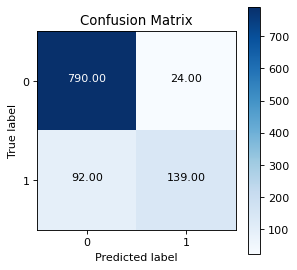

<Figure size 640x480 with 0 Axes>

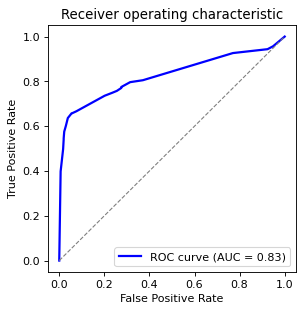

In [31]:
skf = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
# Create a decision tree model with optimal hyperparameters
test_decision_tree = tree.DecisionTreeClassifier(random_state=0, max_depth=9, min_samples_split=3)

# Create a stratified train-test split to calculate confusion and ROC
train_idx, test_idx = next(iter(skf.split(clustered_reduced_featurized_data.iloc[:, 1:-1], clustered_reduced_featurized_data.iloc[:, 0])))

# Get train and test splits
train_set_X = clustered_reduced_featurized_data.iloc[train_idx, 1:-1]
train_set_y = clustered_reduced_featurized_data.iloc[train_idx, 0]

test_set_X = clustered_reduced_featurized_data.iloc[test_idx, 1:-1]
test_set_y = clustered_reduced_featurized_data.iloc[test_idx, 0]

# Fit test model with optimal hyperparameters
test_decision_tree.fit(train_set_X, train_set_y)

# Get model predictions on test set
y_pred = test_decision_tree.predict(test_set_X)

# Plot confusion matrix
conf_matrix = confusion_matrix(test_set_y, y_pred)
plt.figure()
figure(figsize=(4,4), dpi=80)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.grid(False)
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(conf_matrix[i, j], '.2f'), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")
plt.show()
        
# Plot ROC-AUC curve
y_score = test_decision_tree.predict_proba(test_set_X)[:, 1]
fpr, tpr, thresholds = roc_curve(test_set_y, y_score)
roc_auc = roc_auc_score(test_set_y, y_score)
plt.figure()
figure(figsize=(4,4), dpi=80)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# 2.4 Training a full data decision tree

In [32]:
full_data_decision_tree_X = clustered_reduced_featurized_data.iloc[:, 1:-1]
full_data_decision_tree_y = clustered_reduced_featurized_data.iloc[:, 0]

In [33]:
full_data_decision_tree = tree.DecisionTreeClassifier(random_state=0, max_depth=9, min_samples_split=3)
full_data_decision_tree.fit(full_data_decision_tree_X,full_data_decision_tree_y)

DecisionTreeClassifier(max_depth=9, min_samples_split=3, random_state=0)

The decision tree is too large to view within this Jupyter notebook. As a result, only the first five layers are plotted (the most important features). To see all the details of the tree, with the feature names, please right-click on the image produced and open in a new tab.

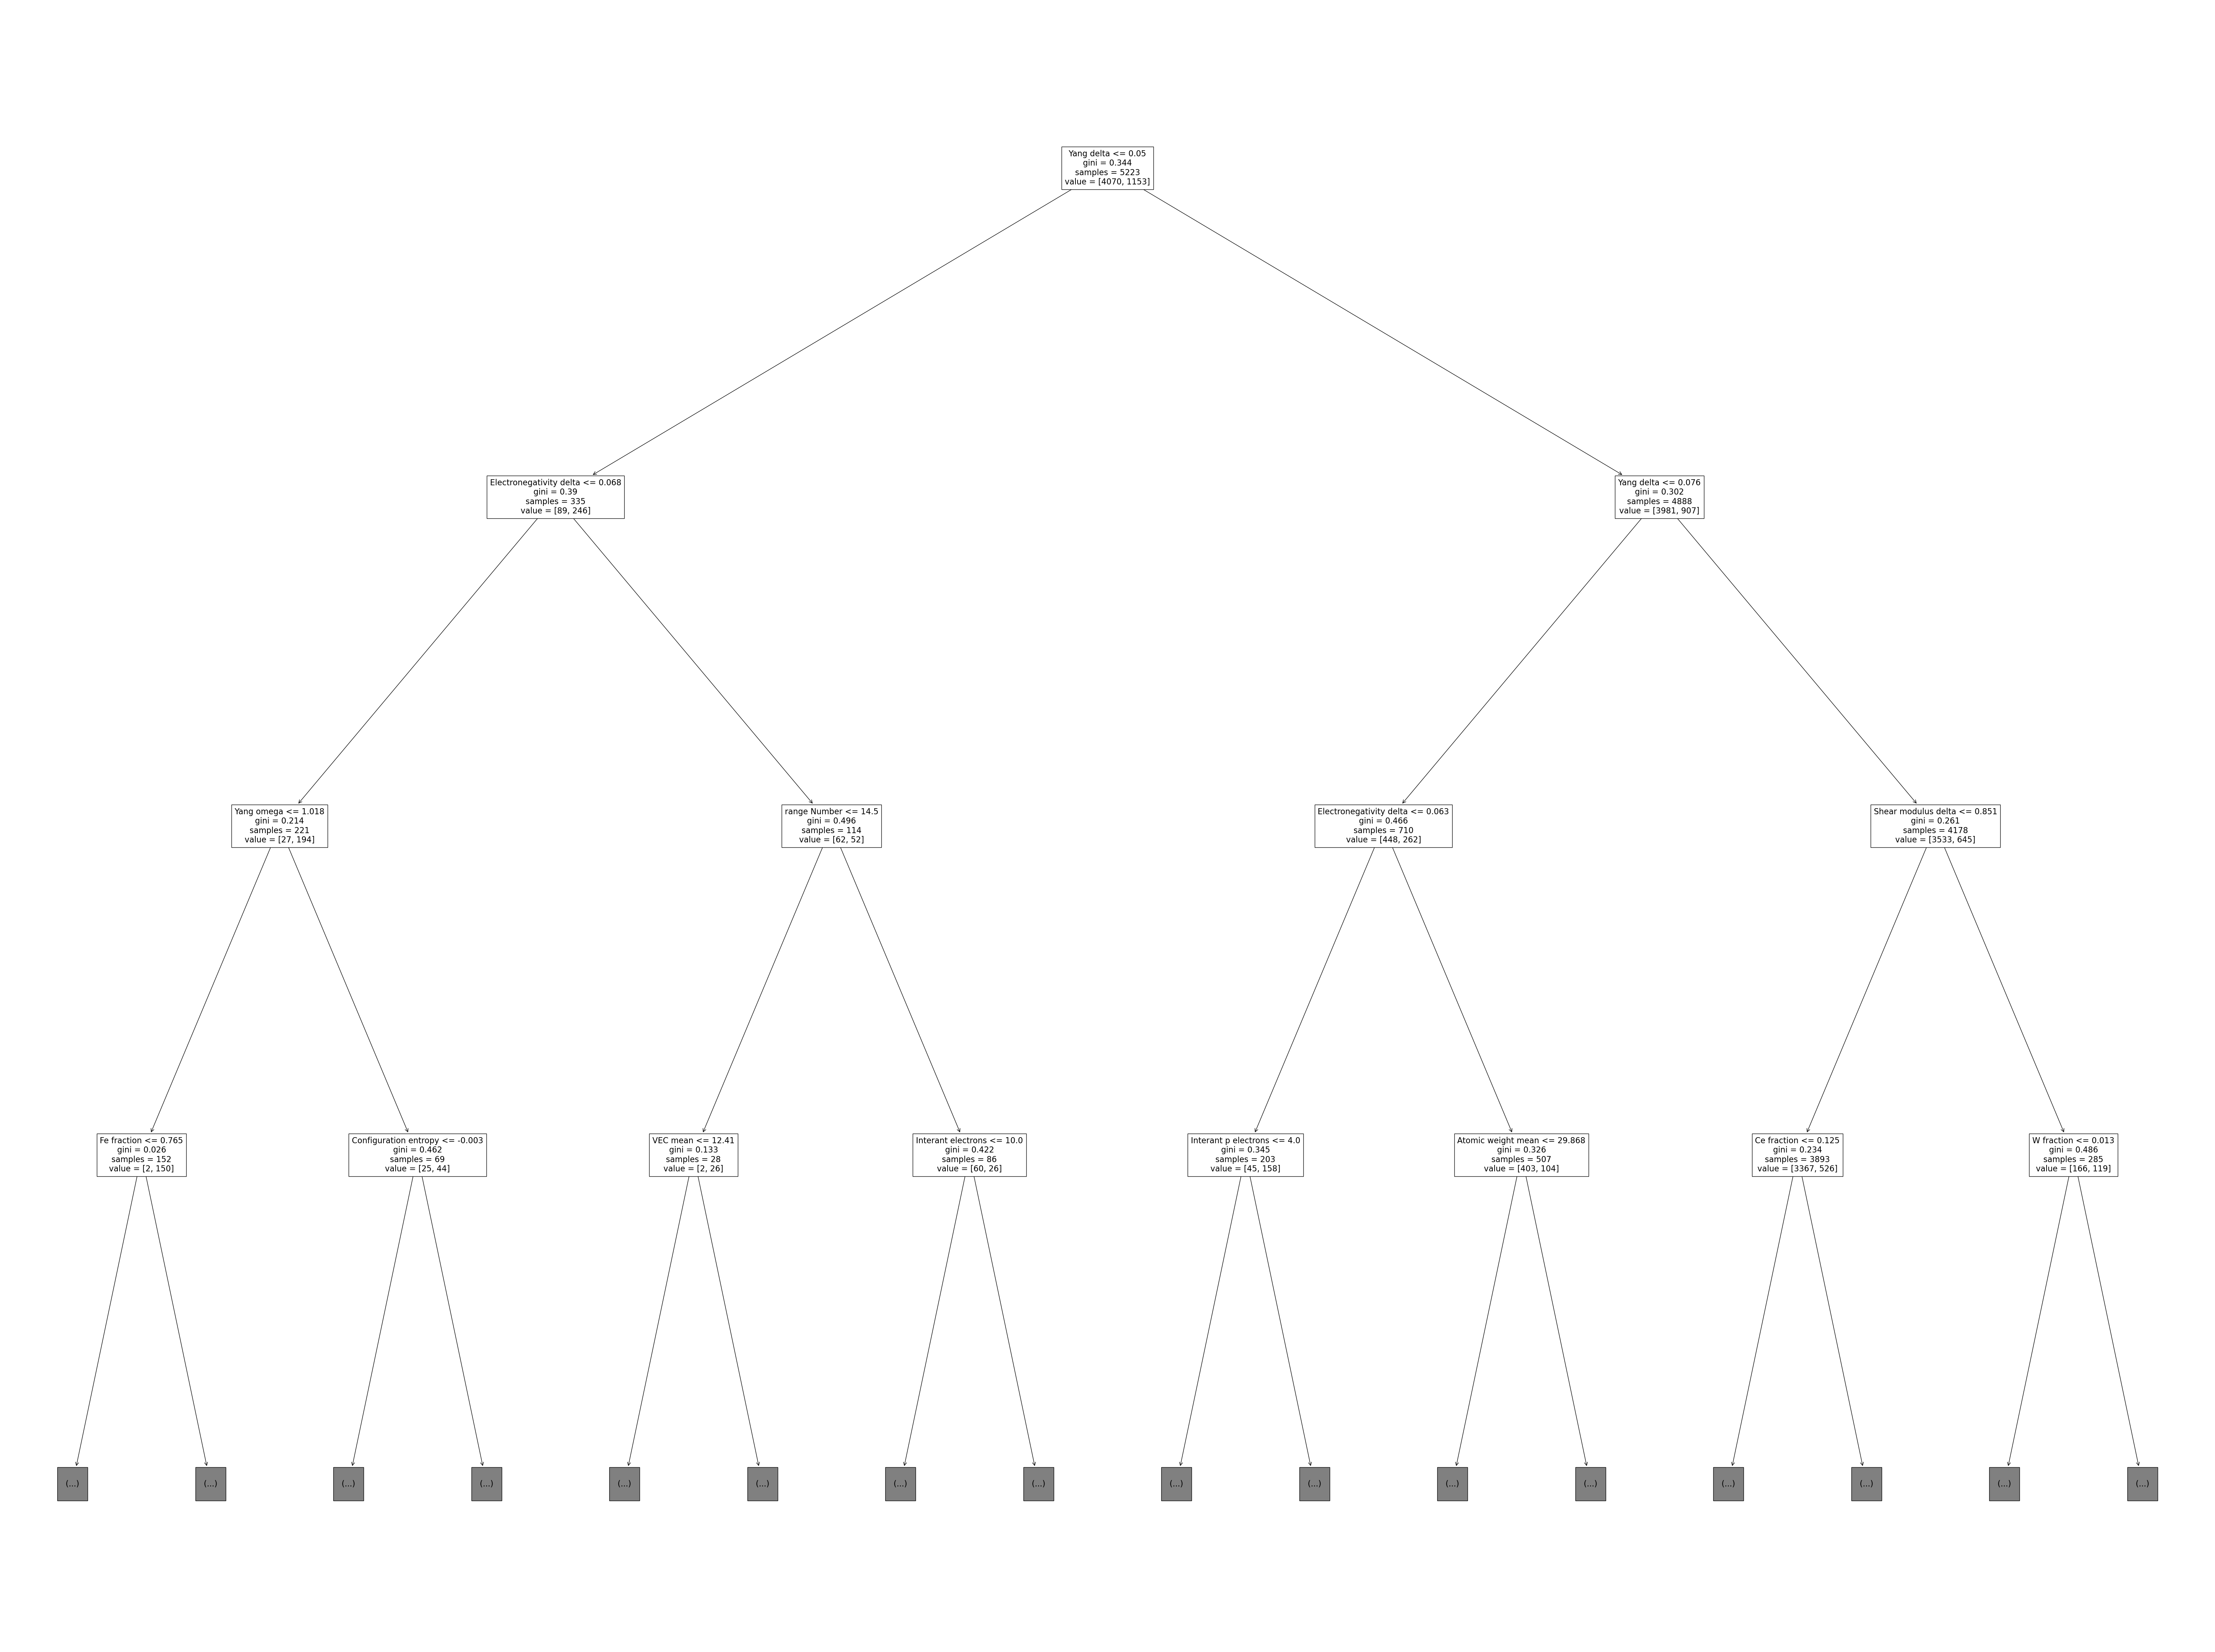

In [34]:
plt.figure(figsize = (80,60))
full_DT_pic = tree.plot_tree(full_data_decision_tree, max_depth=3, feature_names = list(full_data_decision_tree_X.columns))

# 3.0 Training a Random Forest Classifier

## 3.1 Performing LOCO-CV (using same cluster labels from Section 2.1)

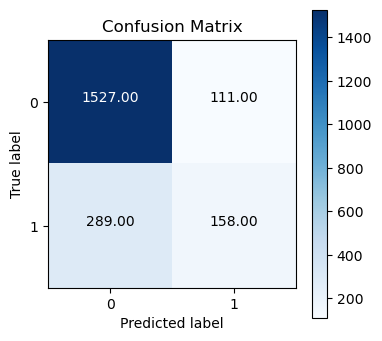

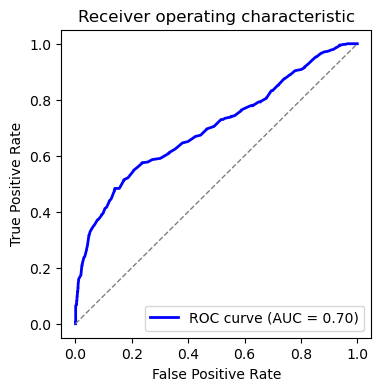

The training error is 0.2868 %
The test error is 19.1847 % 


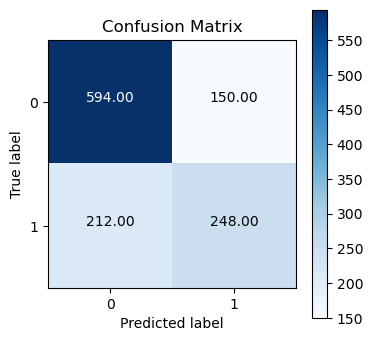

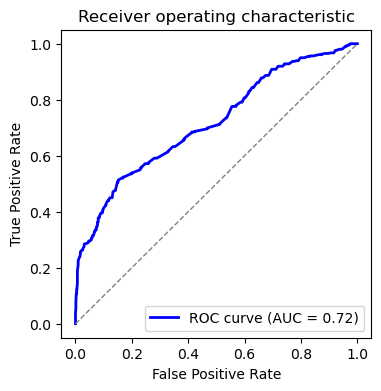

The training error is 0.3483 %
The test error is 30.0664 % 


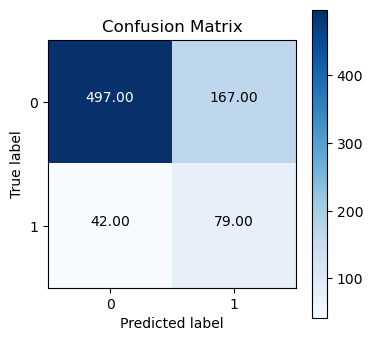

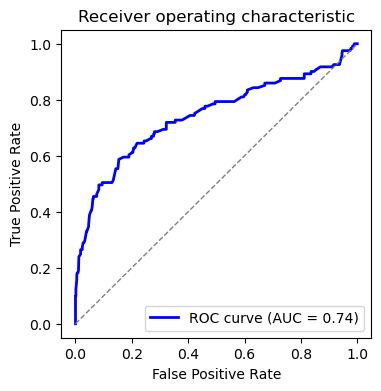

The training error is 0.3605 %
The test error is 26.6242 % 


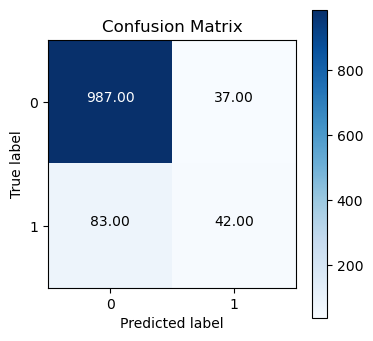

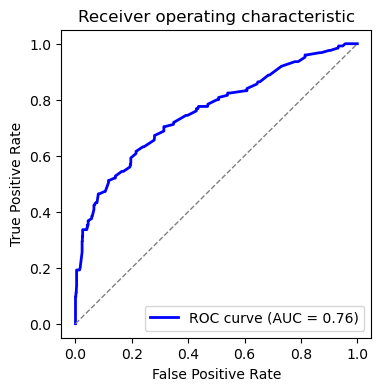

The training error is 0.2209 %
The test error is 10.4439 % 


In [35]:
rdforest_loco_scores, rdforest_loco_test_errors, rdforest_loco_trainerrors = tree_cv(clustered_reduced_featurized_data, cv_type='loco', model_type="randomforest")

## 3.2 Performing random-CV

In [36]:
tuned_parameters = {'max_depth': [12,13,14,15,16], 
                     'n_estimators': [50,75,100,125,150]}

# Compute accuracy
# Error is 1 - accuracy
scores = ['accuracy'] 
for score in scores:
    splitting_type = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    clf = GridSearchCV(RandomForestClassifier(random_state=0), tuned_parameters,
                       scoring = f'{score}', return_train_score=True, cv=splitting_type)
    clf.fit(randomcv_X, randomcv_y)
    print("Training and test set errors from grid search:")
    print()
    # Get mean validation accuracy over folds for each pair of hyperparameters
    means = clf.cv_results_["mean_test_score"]
    # Get mean training accuracy over folds for each pair of hyperparameters
    train_means = clf.cv_results_["mean_train_score"]
    # Get standard deviation of validation accuracy scores 
    stds = clf.cv_results_["std_test_score"]
    # Get standard deviation of training accuracy scores 
    train_stds = clf.cv_results_["std_train_score"]
    # Report your training and validation errors
    for mean, std, train_means, train_stds, params in zip(means, stds, train_means, train_stds, clf.cv_results_['params']):
        print(f"Test error: {1 - mean:0.3f} (+/-{std*2:0.03f}), Training error: {1 - train_means:0.3f} (+/-{train_stds*2:0.03f}) for {params}")


Training and test set errors from grid search:

Test error: 0.098 (+/-0.018), Training error: 0.053 (+/-0.006) for {'max_depth': 12, 'n_estimators': 50}
Test error: 0.100 (+/-0.018), Training error: 0.055 (+/-0.004) for {'max_depth': 12, 'n_estimators': 75}
Test error: 0.100 (+/-0.018), Training error: 0.055 (+/-0.003) for {'max_depth': 12, 'n_estimators': 100}
Test error: 0.101 (+/-0.017), Training error: 0.055 (+/-0.003) for {'max_depth': 12, 'n_estimators': 125}
Test error: 0.100 (+/-0.016), Training error: 0.055 (+/-0.004) for {'max_depth': 12, 'n_estimators': 150}
Test error: 0.094 (+/-0.021), Training error: 0.041 (+/-0.003) for {'max_depth': 13, 'n_estimators': 50}
Test error: 0.096 (+/-0.018), Training error: 0.043 (+/-0.004) for {'max_depth': 13, 'n_estimators': 75}
Test error: 0.097 (+/-0.016), Training error: 0.043 (+/-0.002) for {'max_depth': 13, 'n_estimators': 100}
Test error: 0.097 (+/-0.018), Training error: 0.043 (+/-0.002) for {'max_depth': 13, 'n_estimators': 125}
Te

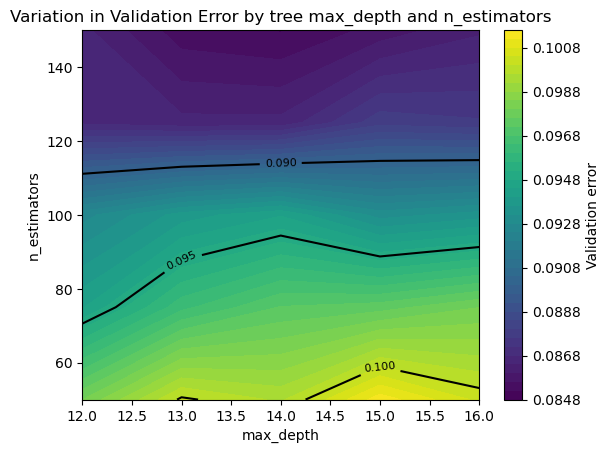

In [37]:
# Plot contour plot
X, Y = np.meshgrid(tuned_parameters['max_depth'], tuned_parameters['n_estimators'])
# Color is validation error = 1 - mean validation accuracy
Z = np.array(1 - means).reshape(5,5)
plt.figure()
plt.contourf(X, Y, Z, 50)
plt.colorbar(label='Validation error');
 
contours = plt.contour(X, Y, Z, 3, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.title("Variation in Validation Error by tree max_depth and n_estimators")
plt.show()

The optimal hyperparatemers appear to be n_estimators = 110 (approximately) and max_depth = 12, as this gives a valdiation error of 9% and increasing either of these parameters does not significantly decrease validation error

## 3.3 Confusion matrix and ROC curve for random forest with tuned hyperparameters

The same one-fold test-train split that was used to produce the confusion matrix for the turned decision tree model is used again here (to make the comparison between both models easier).

<Figure size 640x480 with 0 Axes>

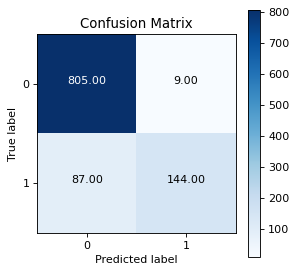

<Figure size 640x480 with 0 Axes>

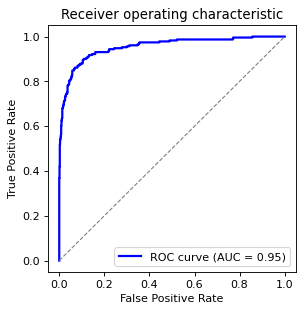

In [38]:
# Create a decision tree model with optimal hyperparameters
test_random_forest_tree = RandomForestClassifier(random_state=0, max_depth=12, n_estimators=110)

# Fit test model with optimal hyperparameters
test_random_forest_tree.fit(train_set_X, train_set_y)

# Get model predictions on test set
random_forest_y_pred = test_random_forest_tree.predict(test_set_X)
# Plot confusion matrix
conf_matrix = confusion_matrix(test_set_y, random_forest_y_pred)
plt.figure()
figure(figsize=(4,4), dpi=80)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.grid(False)
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(conf_matrix[i, j], '.2f'), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")
plt.show()
        
# Plot ROC-AUC curve
y_score = test_random_forest_tree.predict_proba(test_set_X)[:, 1]
fpr, tpr, thresholds = roc_curve(test_set_y, y_score)
roc_auc = roc_auc_score(test_set_y, y_score)
plt.figure()
figure(figsize=(4,4), dpi=80)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## 3.4 Training a full data Random Forest Classifier

In [39]:
full_data_rdforest_X = clustered_reduced_featurized_data.iloc[:, 1:-1]
full_data_rdforest_y = clustered_reduced_featurized_data.iloc[:, 0]

In [40]:
full_data_random_forest_model = RandomForestClassifier(random_state=0, max_depth=12, n_estimators=110)
full_data_random_forest_model.fit(full_data_rdforest_X,full_data_rdforest_y)

RandomForestClassifier(max_depth=12, n_estimators=110, random_state=0)

# 4.0 Predict the Glass forming ability for the entire Co-Zr-Cr-Ti quaternary system using both Decision Tree and Random Forest models

In [41]:
# From Lab 5
# Create table of compositions for quaternary system
elements = ['Co', 'Ti', 'Zr', 'Cr']

# Define the increment for atomic fractions
increment = 0.05

# Create an empty list to store the rows of the DataFrame
rows = []

# Generate all possible combinations of atomic fractions
for i in range(0, 21):
    for j in range(0, 21):
        for k in range(0, 21):
            # Compute the atomic fraction for the last element
            l = 20 - i - j - k
            if l < 0:
                continue
            # Compute the atomic fractions for each element
            atomic_fractions = [i*increment, j*increment, k*increment, l*increment]
            # Check if the total atomic fraction is equal to 1
            total_atomic_fraction = sum(atomic_fractions)
            if total_atomic_fraction == 1:
                rows.append(atomic_fractions)

# Create a DataFrame from the list of rows
quaternary_data = pd.DataFrame(rows, columns=elements)

In [42]:
formula = 'Co'+quaternary_data['Co'].astype(str)+'Ti'+quaternary_data['Ti'].astype(str)+'Zr'+quaternary_data['Zr'].astype(str)+'Cr'+quaternary_data['Cr'].astype(str)
quaternary_data['Formula'] = pd.DataFrame(formula)

In [43]:
# str_comp = StrToComposition(target_col_id='composition')
# featurized_quaternary_data = str_comp.featurize_dataframe(quaternary_data, col_id='Formula')
# featurized_quaternary_data.to_csv("featurized_quatcomposition.csv")

In [44]:
# featurized_quaternary_data = WenAlloys().featurize_dataframe(featurized_quaternary_data, "composition")

In [45]:
# featurized_quaternary_data.to_csv("featurized_quat_wenalloys.csv")

In [46]:
# featurized_quaternary_data = Meredig().featurize_dataframe(featurized_quaternary_data, col_id="composition")

In [47]:
# featurized_quaternary_data.to_csv("featurized_quat_meredig.csv")

In [48]:
# featurized_quaternary_data = AtomicPackingEfficiency().featurize_dataframe(featurized_quaternary_data, col_id="composition")

In [49]:
# featurized_quaternary_data.to_csv("raw_featurized_quaternary_data_nonedropped.csv")

Please download **raw_featurized_quaternary_data_nonedropped.csv** before running the rest of the code:

In [50]:
featurized_quaternary_data = pd.read_csv("raw_featurized_quaternary_data_nonedropped.csv")

In [51]:
# Add three  polynomial combinations of two features
quat_polynomial_featurized_data = featurized_quaternary_data
quat_polynomial_featurized_data["APE mean_Radii gamma Product"] = quat_polynomial_featurized_data["APE mean"] * quat_polynomial_featurized_data["Radii gamma"]
quat_polynomial_featurized_data["APE mean_squared"] = quat_polynomial_featurized_data["APE mean"] ** 2
quat_polynomial_featurized_data["APE mean_Total weight Product"] = quat_polynomial_featurized_data["APE mean"] * quat_polynomial_featurized_data["Total weight"]
quat_polynomial_featurized_data = quat_polynomial_featurized_data.dropna()

In [52]:
# Only keep features used for training models
keep_cols = list(reduced_featurized_data.columns[1:-1])
final_quat_data = quat_polynomial_featurized_data[keep_cols]

## 4.1 Full Model Decision Tree Predictions

In [53]:
full_data_decision_tree_predictions = full_data_decision_tree.predict(final_quat_data)
full_data_randomforest_predictions = full_data_random_forest_model.predict(final_quat_data)

In [54]:
quat_data_predictions = final_quat_data
quat_data_predictions = quat_data_predictions[["Yang delta", "Yang omega"]]

In [55]:
pd.options.mode.chained_assignment = None # Ignore warnings
quat_data_predictions["Decision Tree Prediction"] = full_data_decision_tree_predictions
quat_data_predictions["Random Forest Prediction"] = full_data_randomforest_predictions

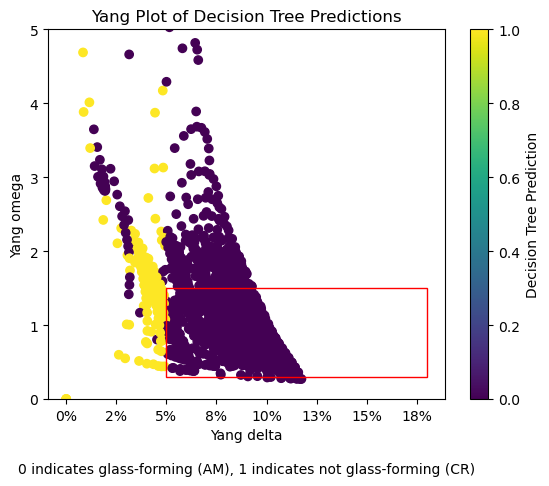

In [56]:
plot_dataframe(quat_data_predictions, "Decision Tree Prediction", title= "Yang Plot of Decision Tree Predictions", overlay_rect=True)

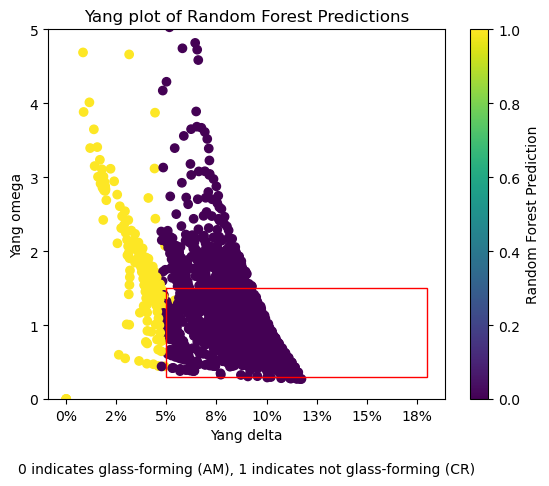

In [57]:
plot_dataframe(quat_data_predictions, "Random Forest Prediction", title="Yang plot of Random Forest Predictions", overlay_rect=True)

(Sidenote) Determining how many times the decision tree predictions differ from the random forest predictions

In [58]:
prediction_similarity = full_data_decision_tree_predictions == full_data_randomforest_predictions

In [59]:
pd.DataFrame(prediction_similarity).value_counts()

True     1524
False      60
dtype: int64

# Summary

Comparing the Yang Plots of both models, they both seems to predict very similar results. Upon comparing with the Yang heuristic (red rectangle) of the glass-forming regime, it seems that the Random Forest model identifies more data points outside thiss region as being crystalline, which is more realistic. More specifically, the two models have different predictions for only on 60/1584 (~3.8%). This indicates that the fits of both models are of comparable quality.

Comparing feature importances:

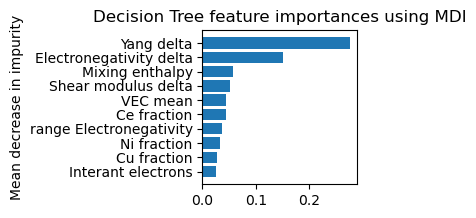

Text(0, 0.5, 'Mean decrease in impurity')

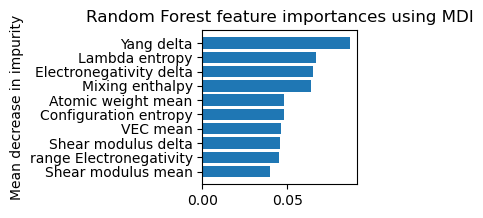

In [60]:
DT_importances = full_data_decision_tree.feature_importances_
sort = DT_importances.argsort()
plt.figure(figsize = (2,2))
plt.barh(full_data_decision_tree_X.columns[sort][-10:], DT_importances[sort][-10:])
plt.title("Decision Tree feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
plt.show()
plt.figure(figsize = (2,2))
RF_importances = full_data_random_forest_model.feature_importances_
RFstd = np.std([full_data_random_forest_model.feature_importances_ for tree in full_data_random_forest_model.estimators_], axis=0)
sort = RF_importances.argsort()
plt.barh(full_data_rdforest_X.columns[sort][-10:], RF_importances[sort][-10:], xerr=RFstd[sort][-10:])
plt.title("Random Forest feature importances using MDI")
plt.ylabel("Mean decrease in impurity")

For both models, Yang delta had the greatest importance and Electronegativity delta was in the top 3. The Random Forest model, however considers more thermodynamic properties as being important (such as mixing enthalpy, configurational entropy), whereas the decision tree relied on more mechanical properties (e.g. shear modulus delta).

The models likely differ in their predictions for the Quaternary system due to the differences in assigning importance to different features. It appears that the Random Forest model weights individual features less heavility than the decision tree model. For example, Yang delta has an importance of about 0.25 in the decision tree and only 0.08 in the random forest. This suggests that the random forest model considers more material properties when making a prediction compared to the decision tree.

Based on the Cross Validation statistics, I would believe the Random Forest model more as it has a lower validation error and higher AUC score than the decision tree model. These both suggests the Random Forest model has more accurate predictive power on unseen data.

Ploting both model predictions on the full training set in a reduced dimensional space (first two principal components) with the points colored for **AM (purple) and CR (yellow)**:

Text(0, 0.5, 'PC2')

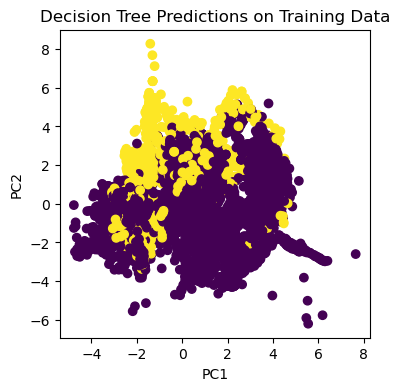

In [61]:
plt.figure(figsize = (4,4))
plt.scatter(pos[:,0],pos[:,1],c = full_data_decision_tree.predict(full_data_decision_tree_X))
plt.title('Decision Tree Predictions on Training Data')
plt.xlabel('PC1')
plt.ylabel('PC2')

Text(0, 0.5, 'PC2')

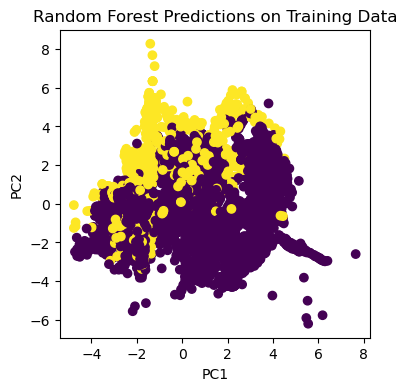

In [62]:
plt.figure(figsize = (4,4))
plt.scatter(pos[:,0],pos[:,1],c = full_data_random_forest_model.predict(full_data_rdforest_X))
plt.title('Random Forest Predictions on Training Data')
plt.xlabel('PC1')
plt.ylabel('PC2')

For both models, the colored points somewhat cluster in the reduced dimensional space of the training data, however for the most part the data points are widely scattered (i.e. the yellow points are spread across PC1 from -4 to 5, which is a large range). This suggests that both models are extrapolating beyond the training data.

I would expect that if the models were primarily interpolating, then yellow points (glass-forming) would cluster together in reduced-dimensional space more tightly (same with the purple, non-glass forming points).